In [5]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define paths and constants
results_dir = "../results/boron_inversion"

# Load all batch results
all_results = {}

batch_ranges = [
    (504, 509), (509, 514), (514, 519), (519, 524), (524, 529),
    (529, 534), (534, 539), (539, 544), (544, 549), (549, 554),
    (554, 559), (559, 564), (564, 569), (569, 574), (574, 579),
    (579, 584), (584, 589), (589, 594), (594, 599), (599, 604),
    (604, 609), (609, 614), (614, 619), (619, 624)
]

# Initialize results container
all_results = {
    "best_preds": [],
    "processing_time": 0.0
}

# Load all batch files
for start_idx, end_idx in batch_ranges:
    filename = f"{results_dir}/boron_inversion_final_batch_{start_idx}_{end_idx}.pkl"
    try:
        with open(filename, "rb") as f:
            batch_results = pickle.load(f)
            all_results["best_preds"].extend(batch_results["best_preds"])
            all_results["processing_time"] += batch_results["processing_time"]
        print(f"Loaded results from {filename}")
    except FileNotFoundError:
        print(f"Warning: File not found: {filename}")
    except Exception as e:
        print(f"Error loading {filename}: {str(e)}")

# Check if any results were loaded
if not all_results["best_preds"]:
    print("Warning: No results were loaded.")
else:
    print(f"Loaded results for {len(all_results['best_preds'])} environments with total processing time {all_results['processing_time']:.2f} seconds.")


Loaded results from ../results/boron_inversion/boron_inversion_final_batch_504_509.pkl
Loaded results from ../results/boron_inversion/boron_inversion_final_batch_509_514.pkl
Loaded results from ../results/boron_inversion/boron_inversion_final_batch_514_519.pkl
Loaded results from ../results/boron_inversion/boron_inversion_final_batch_519_524.pkl
Loaded results from ../results/boron_inversion/boron_inversion_final_batch_524_529.pkl
Loaded results from ../results/boron_inversion/boron_inversion_final_batch_529_534.pkl
Loaded results from ../results/boron_inversion/boron_inversion_final_batch_534_539.pkl
Loaded results from ../results/boron_inversion/boron_inversion_final_batch_539_544.pkl
Loaded results from ../results/boron_inversion/boron_inversion_final_batch_544_549.pkl
Loaded results from ../results/boron_inversion/boron_inversion_final_batch_549_554.pkl
Loaded results from ../results/boron_inversion/boron_inversion_final_batch_554_559.pkl
Loaded results from ../results/boron_invers

/var/folders/7c/7cx32s8x1x32j9xw0z_x3y980000gn/T/ipykernel_75888/358929345.py:32: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  batch_results = pickle.load(f)


In [6]:
with open('../data/boron_structures.pkl', 'rb') as f:
    local_envs = pickle.load(f)

local_envs = local_envs[504:624]

print(f"Number of local environments: {len(local_envs)}")

Number of local environments: 120


In [14]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)
import spectra as spectra
from utils.plotters import visualize_signal
from utils.alignment import point_distance
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import numpy as np
from scipy.spatial.transform import Rotation
import itertools


def align_predicted_geometry(true_geometry: np.ndarray,
                             predicted_geometry: np.ndarray
                            ) -> tuple[np.ndarray, float]:
    """
    Aligns `predicted_geometry` onto `true_geometry` using only a rigid-body rotation.
    Points are first sorted by distance from the origin, normalized to unit radius,
    then each pair of corresponding direction‐vectors is scaled by a different
    random weight (to break any geometric symmetry) before computing the optimal
    rotation. Assumes both inputs are centered at the origin.

    Parameters
    ----------
    true_geometry : (N, 3) array_like
        Reference point cloud, centered at the origin.
    predicted_geometry : (N, 3) array_like
        Point cloud to align, also centered.

    Returns
    -------
    aligned_predicted : (N, 3) ndarray
        The `predicted_geometry` rotated to best match `true_geometry`.
    rmsd : float
        The RMSD between the (weighted) direction‐vectors after optimal alignment.
    """
    # Convert inputs
    true_pts = np.asarray(true_geometry, dtype=float)
    pred_pts = np.asarray(predicted_geometry, dtype=float)
    if true_pts.shape != pred_pts.shape or true_pts.shape[1] != 3:
        raise ValueError("Both inputs must have shape (N, 3)")

    # Compute norms (radii) without sorting
    true_radii = np.linalg.norm(true_pts, axis=1)
    pred_radii = np.linalg.norm(pred_pts, axis=1)
    
    # Normalize to unit vectors directly without reordering
    true_dirs = true_pts / true_radii[:, None]
    pred_dirs = pred_pts / pred_radii[:, None]    

    # Generate a different random weight for each point to break symmetry
    # (e.g. uniform on [0,1) or any other distribution)
    weights = np.random.rand(true_dirs.shape[0], 1)

    # Scale both sets by the same per-point weights
    true_weighted = true_dirs * weights
    pred_weighted = pred_dirs * weights

    # Compute optimal rotation on weighted directions
    rot, rmsd = Rotation.align_vectors(true_weighted, pred_weighted)

    # Apply rotation back to the original predicted points
    pred_rotated = rot.apply(pred_pts)

    return pred_rotated, rmsd


def alignment_mae(true_geometry, predicted_geometry):

    true_geometry = np.array(true_geometry)
    predicted_geometry = np.array(predicted_geometry)

    if true_geometry.shape != predicted_geometry.shape:
        return float('inf'), None

    # Try all permutations of the predicted geometry and select the one with lowest RMSD
    best_error = float('inf')
    best_aligned = None
    
    # Get all permutations of indices
    n_points = predicted_geometry.shape[0]
    for perm in itertools.permutations(range(n_points)):
        perm_predicted = predicted_geometry[list(perm)]
        aligned, _ = align_predicted_geometry(true_geometry, perm_predicted)
        error = jnp.mean(jnp.linalg.norm(aligned - true_geometry, axis=1))
        # error = np.mean(np.abs(aligned - true_geometry), axis=1)
        if error < best_error:
            best_error = error
            best_aligned = aligned

    return best_error#, best_aligned

In [15]:
len(all_results['best_preds'])

120

In [39]:
np.average(all_results['processing_time']) / 120

np.float64(1124.952484623591)

In [17]:
from tqdm import tqdm

alignment_maes = []
for index in tqdm(range(120)):
    alignment_maes.append(alignment_mae(local_envs[index], all_results['best_preds'][index]))

100%|██████████| 120/120 [00:58<00:00,  2.03it/s]


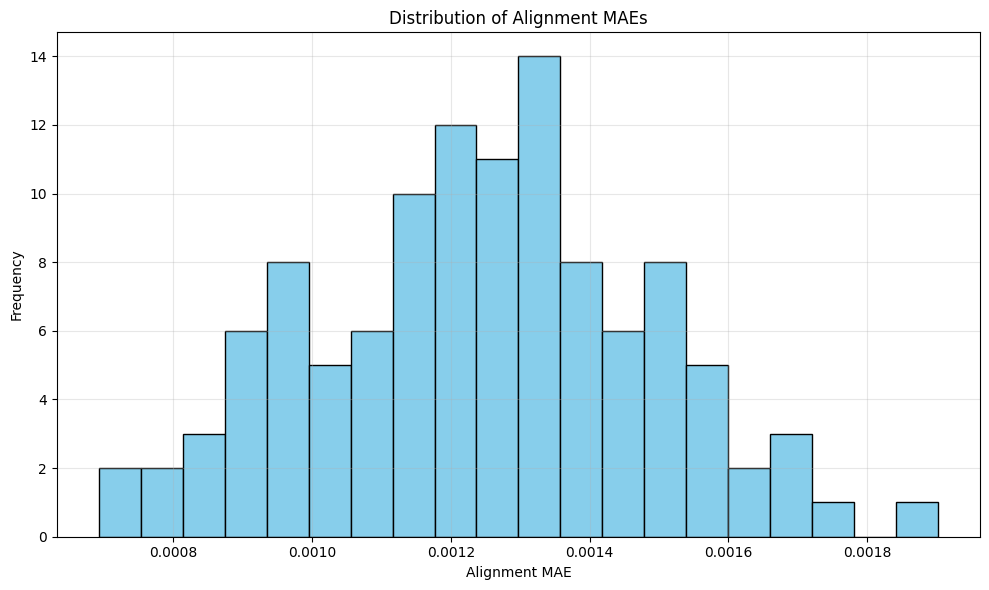

[Array(0.00092876, dtype=float64),
 Array(0.00175254, dtype=float64),
 Array(0.00134093, dtype=float64),
 Array(0.00096924, dtype=float64),
 Array(0.00119762, dtype=float64),
 Array(0.00131737, dtype=float64),
 Array(0.00138803, dtype=float64),
 Array(0.00163331, dtype=float64),
 Array(0.0012534, dtype=float64),
 Array(0.00087945, dtype=float64),
 Array(0.00120067, dtype=float64),
 Array(0.00160769, dtype=float64),
 Array(0.00096468, dtype=float64),
 Array(0.00070841, dtype=float64),
 Array(0.00116279, dtype=float64),
 Array(0.00155557, dtype=float64),
 Array(0.13716115, dtype=float64),
 Array(0.00130665, dtype=float64),
 Array(0.0013163, dtype=float64),
 Array(0.00095846, dtype=float64),
 Array(0.00158212, dtype=float64),
 Array(0.00122196, dtype=float64),
 Array(0.00145452, dtype=float64),
 Array(0.00137468, dtype=float64),
 Array(0.0008301, dtype=float64),
 Array(0.00136256, dtype=float64),
 Array(0.00121868, dtype=float64),
 Array(0.00112712, dtype=float64),
 Array(0.00077328, dtyp

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy array for easier handling
alignment_maes_array = np.array(sorted(alignment_maes)[:-7])

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(alignment_maes_array, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Alignment MAE')
plt.ylabel('Frequency')
plt.title('Distribution of Alignment MAEs')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Also display the array for reference
alignment_maes

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


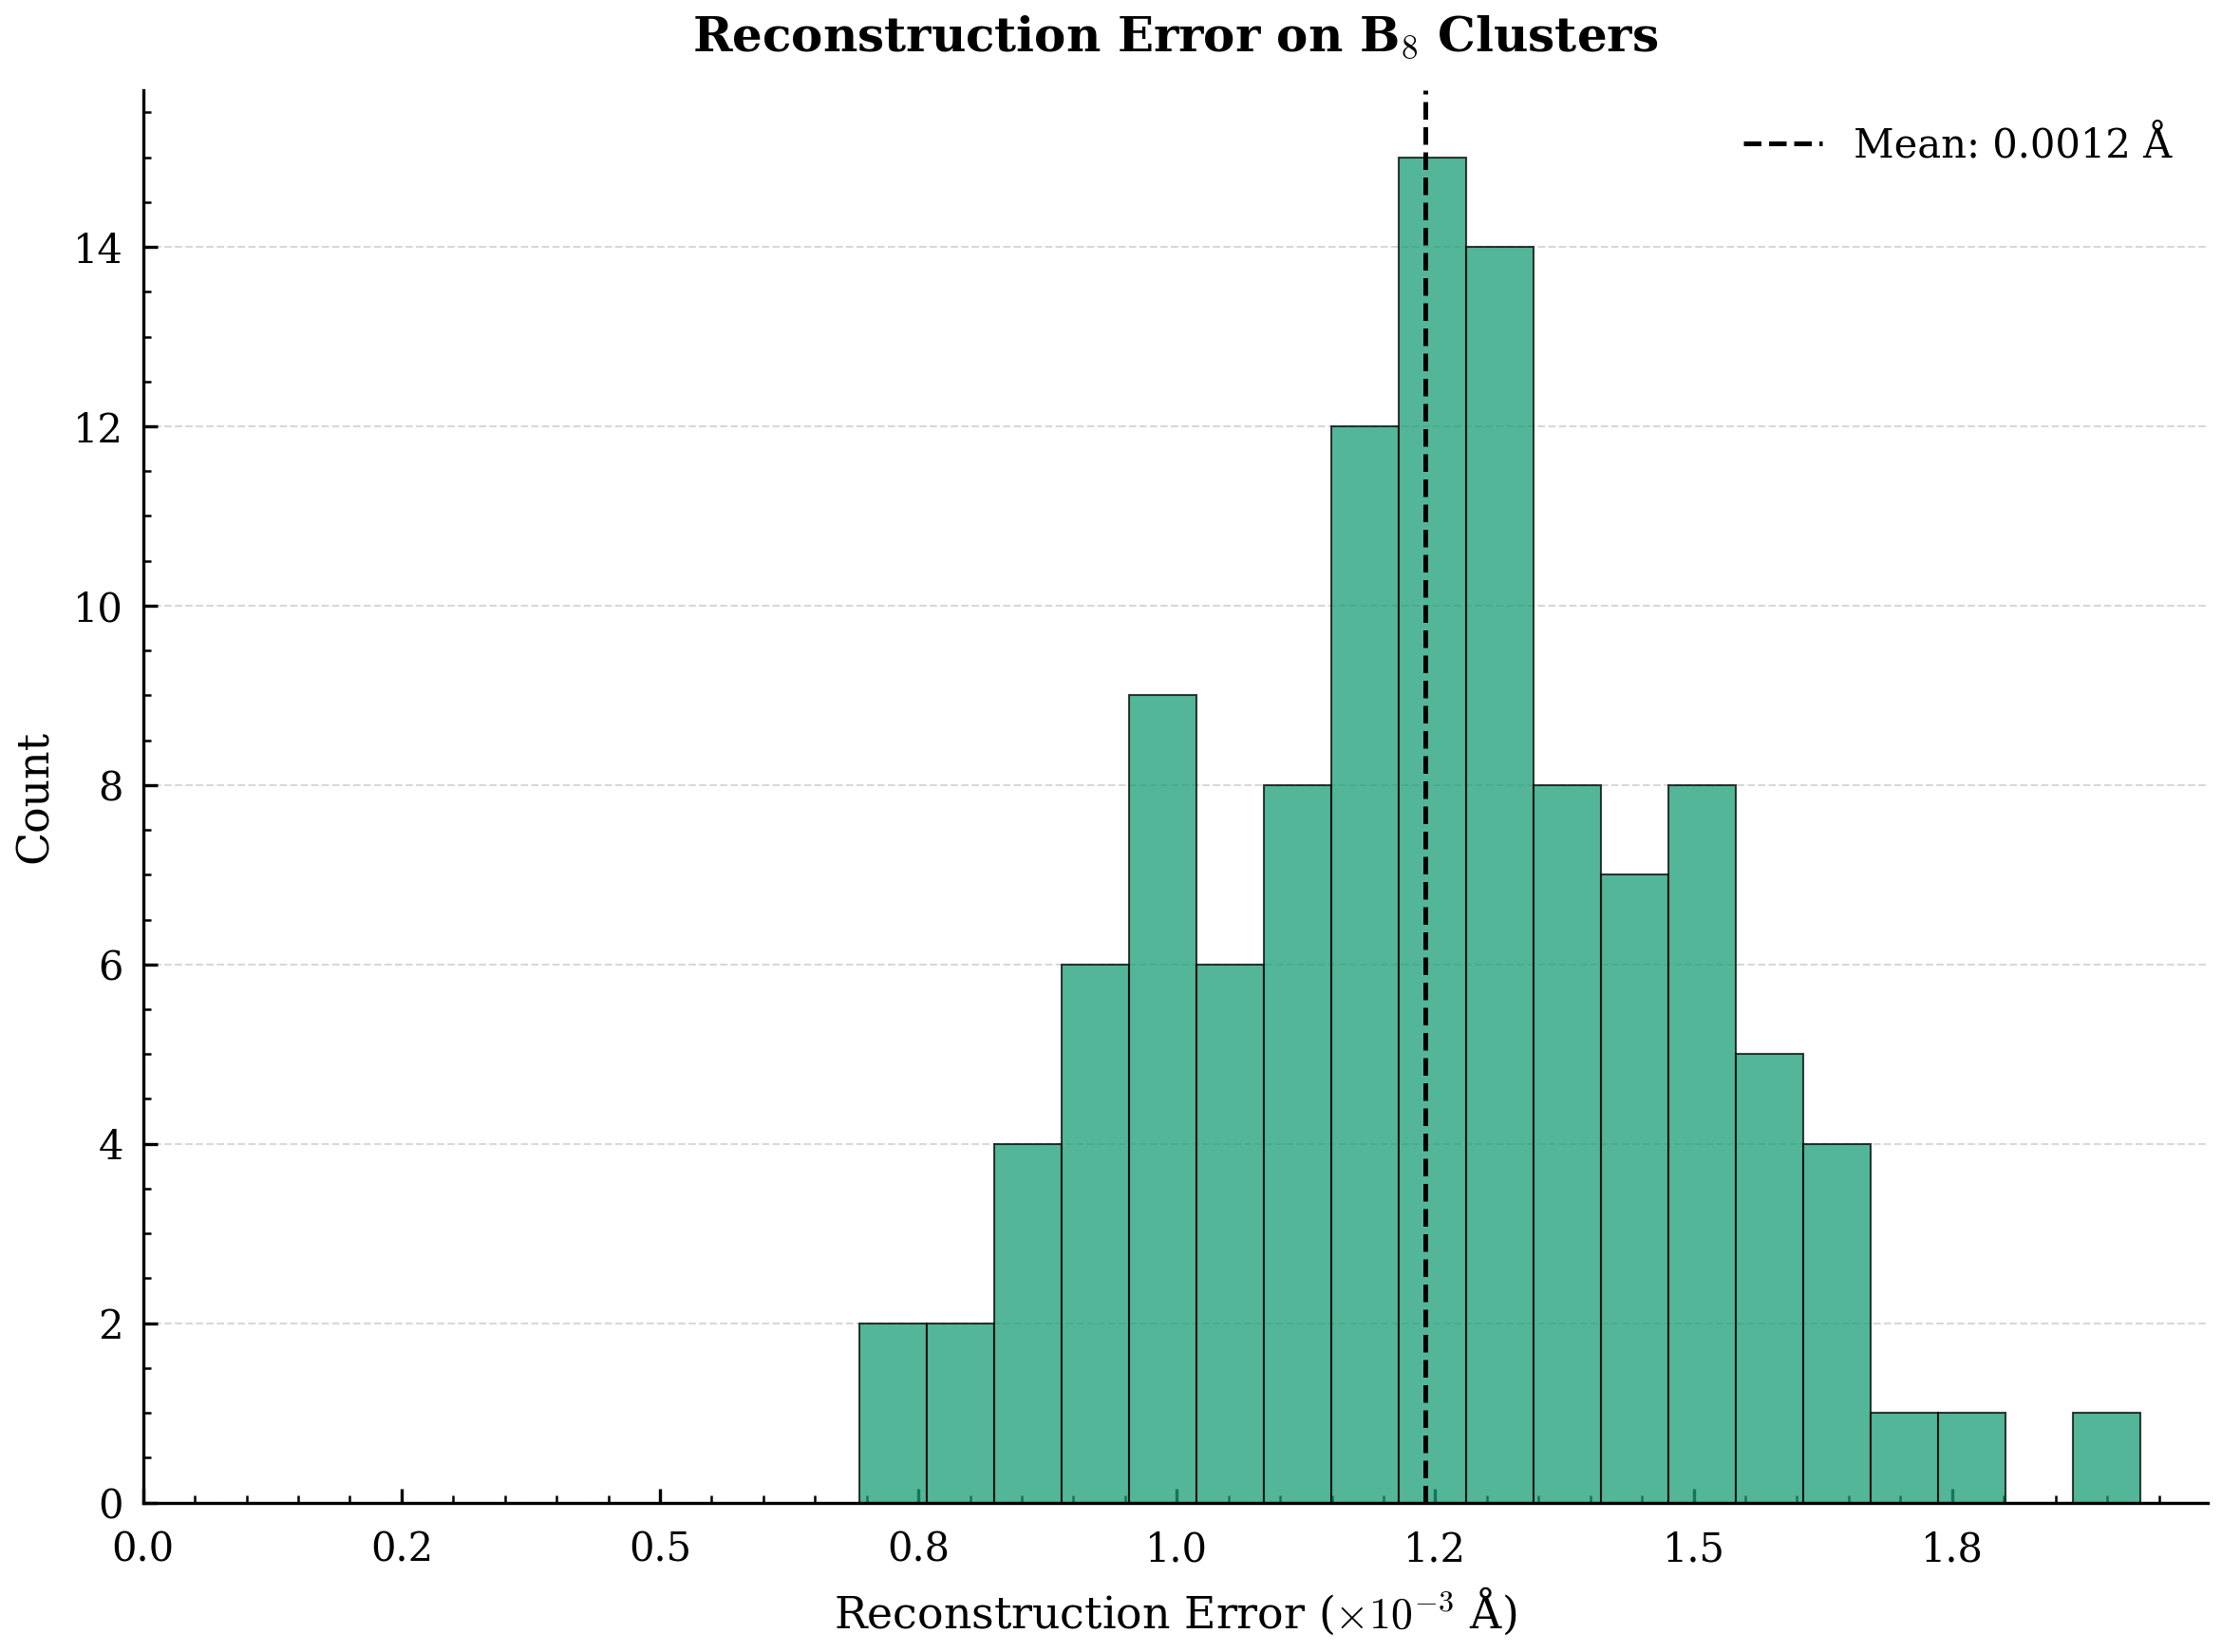

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Set publication-quality plot style
plt.rcParams.update({
    'text.usetex': False,  # Don't use LaTeX for text rendering
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman'],
    'mathtext.fontset': 'cm',  # Still use Computer Modern for math
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.6,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 3.5,
    'ytick.major.size': 3.5,
    'xtick.minor.size': 2.0,
    'ytick.minor.size': 2.0,
    'axes.axisbelow': True,
    'axes.grid': False,
})

# Convert to numpy array for easier handling
# Assuming alignment_maes is your data array
alignment_maes_array = np.array(sorted(alignment_maes)[:-7])

# Calculate statistics for annotation
mean_error = np.mean(alignment_maes_array)
median_error = np.median(alignment_maes_array)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Scale values for the x-axis by multiplying by 1000 (converts from 0.001 to 1.0)
scaled_array = alignment_maes_array * 1000
bin_min = np.min(scaled_array)
bin_max = np.max(scaled_array) * 1.05  # Add 5% padding
bins = np.linspace(bin_min, bin_max, 21)  # 20 bins

# Create histogram with colorblind-friendly color and scaled values
hist, bins, patches = ax.hist(scaled_array, bins=bins, 
                             color='#1b9e77', edgecolor='black', 
                             linewidth=0.5, alpha=0.75)

# Add vertical line at the mean with dashed style (using scaled value)
scaled_mean = mean_error * 1000
ax.axvline(scaled_mean, color='black', linestyle='--', linewidth=1.2, 
           label=f'Mean: {mean_error:.4f} Å')

# Clean up the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.3, color='gray', linewidth=0.5, axis='y')

# Set axis labels with proper formatting and notation
ax.set_xlabel(r'Reconstruction Error ($\times 10^{-3}$ Å)', fontweight='normal')
ax.set_ylabel(r'Count', fontweight='normal')
ax.set_title(r'Reconstruction Error on B$_{8}$ Clusters', fontweight='bold', pad=10)

# Add minor ticks
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

# Function to set scientific notation for large numbers if needed
def sci_format(x, pos):
    if x == 0:
        return "0"
    exp = np.floor(np.log10(abs(x)))
    if abs(exp) > 2:
        return r'$%.1f \times 10^{%d}$' % (x / 10**exp, exp)
    else:
        return '%.3g' % x

# Format x-axis to use simple numbers now that we've scaled by 10^-3
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# Add padding between axes and labels
ax.tick_params(axis='x', pad=7)  # Add padding between x-axis and its labels
ax.tick_params(axis='y', pad=5)  # Add padding between y-axis and its labels

# Add legend with mean value
ax.legend(frameon=False, loc='upper right')

# Make sure all data is visible by setting limits to include all scaled points
# Add a small padding (5%) to ensure bins aren't cut off
max_value = np.max(scaled_array)
ax.set_xlim(0, max_value * 1.05)

# Ensure y-axis starts at 0
ax.set_ylim(bottom=0)

# Adjust layout to match other figures
plt.tight_layout()

# Save the figure in multiple formats suitable for publication
plt.savefig('alignment_error_distribution.pdf', dpi=600, bbox_inches='tight')
plt.savefig('alignment_error_distribution.png', dpi=600, bbox_inches='tight')
plt.savefig('alignment_error_distribution.eps', format='eps', dpi=600, bbox_inches='tight')

plt.show()

In [41]:
for i in range(10):
    print(f"rank {i+1}: {sorted(alignment_maes)[::-1][i]}")

rank 1: 0.13716115074182716
rank 2: 0.08470412442609436
rank 3: 0.06871717825327421
rank 4: 0.03924104783094879
rank 5: 0.008331244667827855
rank 6: 0.006497582835847263
rank 7: 0.0060738652108254685
rank 8: 0.0019021972552090715
rank 9: 0.0017525419239255865
rank 10: 0.001676278169766393


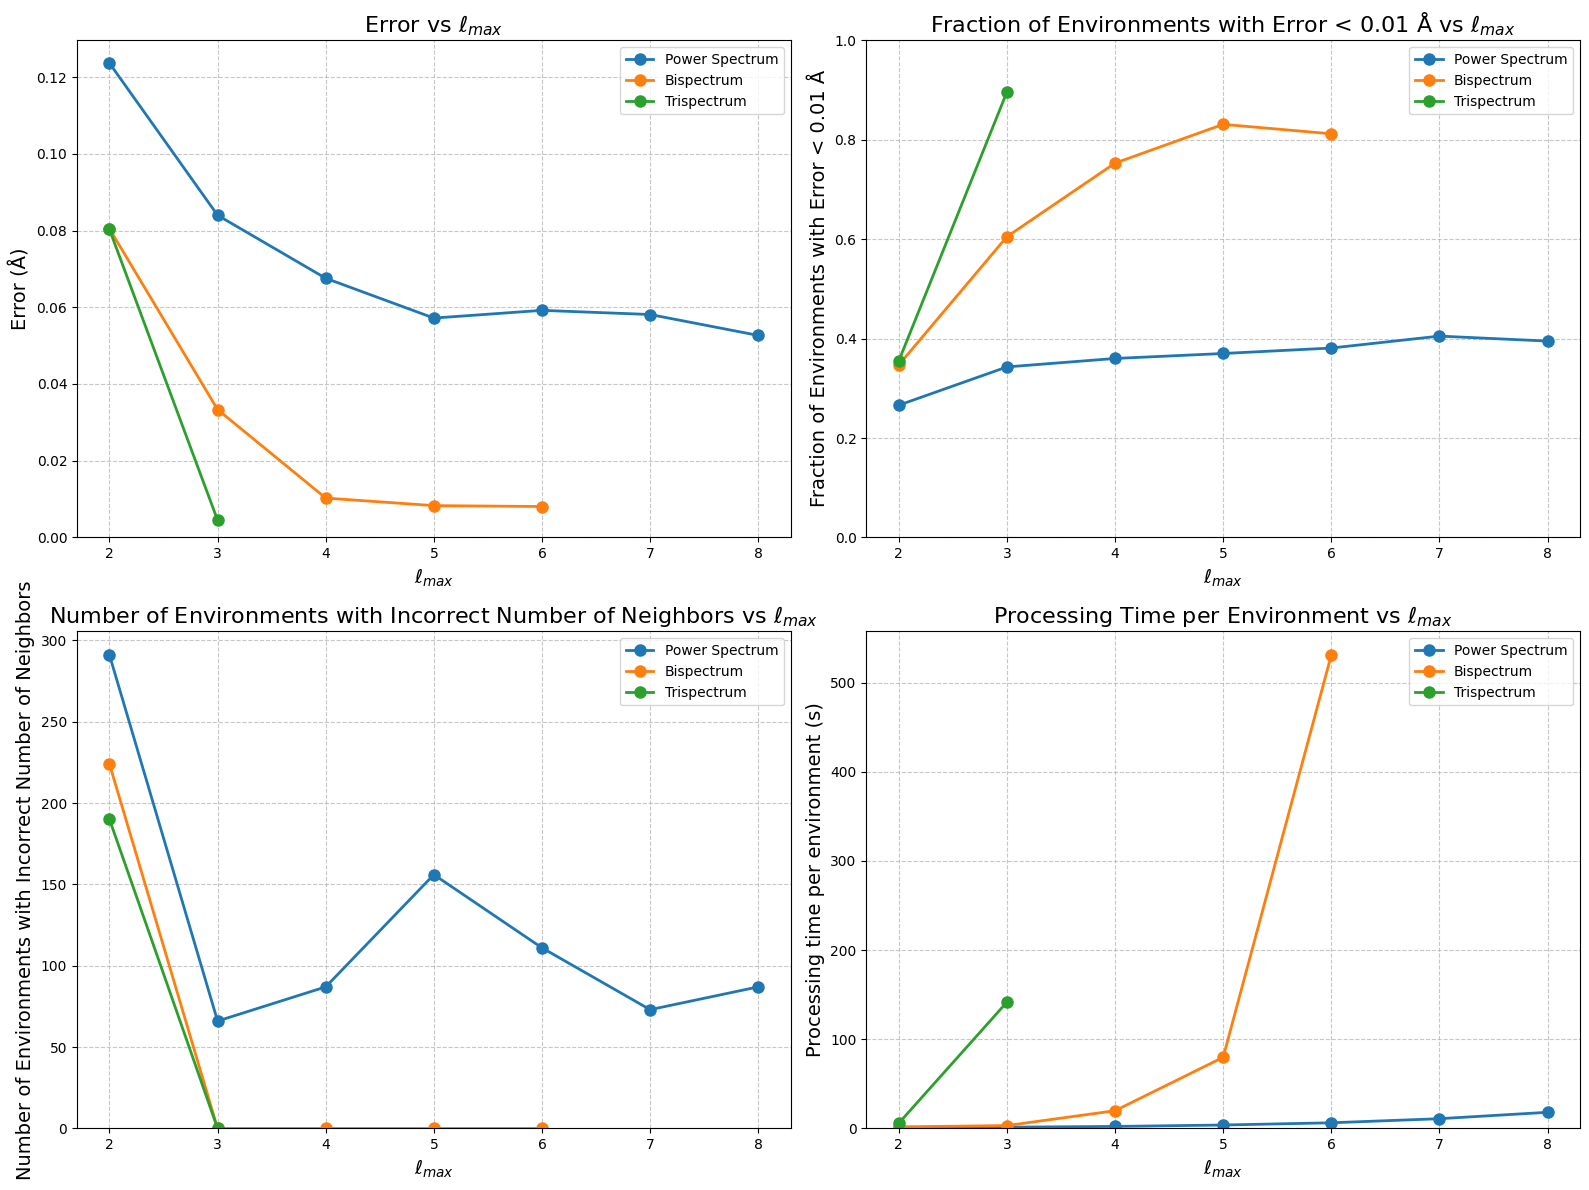

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import tab10

# Create a figure with four subplots in a 2x2 grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Use high contrast colors from a preset colormap
spectrum_colors = {
    'powerspectrum': tab10.colors[0],
    'bispectrum': tab10.colors[1],
    'trispectrum': tab10.colors[2]
}

# Calculate mean alignment MAE and fraction of non-inf values for each method
mean_maes = {}
invalid_alignment_counts = {}
low_mae_fractions = {}
processing_times_per_env = {}

for key in all_results.keys():
    spectrum_name, lmax = key
    
    # Get all MAE values and count non-inf ones
    all_maes = all_results[key]['alignment_mae']
    filtered_maes = [mae for mae in all_maes if not np.isinf(mae)]
    
    # Calculate mean and invalid counts
    mean_maes[key] = np.mean(filtered_maes) if filtered_maes else np.nan
    invalid_alignment_counts[key] = len(all_maes) - len(filtered_maes)
    
    # Calculate fraction of entries with MAE < 0.01
    low_mae_count = sum(1 for mae in all_maes if not np.isinf(mae) and mae < 0.01)
    low_mae_fractions[key] = low_mae_count / len(all_maes) if all_maes else 0
    
    # Calculate processing time per environment
    num_envs = len(local_envs)
    if 'processing_time' in all_results[key]:
        # Check if processing_time is already a total or a list
        if isinstance(all_results[key]['processing_time'], (int, float)):
            processing_times_per_env[key] = all_results[key]['processing_time'] / num_envs
        elif isinstance(all_results[key]['processing_time'], list):
            processing_times_per_env[key] = sum(all_results[key]['processing_time']) / num_envs
        else:
            processing_times_per_env[key] = np.nan
    else:
        processing_times_per_env[key] = np.nan

# Group data by spectrum type
spectrum_data = {}
for spectrum_name in set(key[0] for key in all_results.keys()):
    spectrum_data[spectrum_name] = {
        'lmax': [],
        'mae': [],
        'invalid_alignment_count': [],
        'low_mae_fraction': [],
        'processing_time': []
    }
    
    # Collect data for this spectrum type
    for key in all_results.keys():
        if key[0] == spectrum_name:
            spectrum_data[spectrum_name]['lmax'].append(key[1])
            spectrum_data[spectrum_name]['mae'].append(mean_maes[key])
            spectrum_data[spectrum_name]['invalid_alignment_count'].append(invalid_alignment_counts[key])
            spectrum_data[spectrum_name]['low_mae_fraction'].append(low_mae_fractions[key])
            spectrum_data[spectrum_name]['processing_time'].append(processing_times_per_env[key])
    
    # Sort by lmax
    sorted_indices = np.argsort(spectrum_data[spectrum_name]['lmax'])
    for key in spectrum_data[spectrum_name]:
        spectrum_data[spectrum_name][key] = [spectrum_data[spectrum_name][key][i] for i in sorted_indices]

legend_elements = {
    'powerspectrum': 'Power Spectrum',
    'bispectrum': 'Bispectrum',
    'trispectrum': 'Trispectrum'
}

# Plot the data for each spectrum type
for spectrum_name in ["powerspectrum", "bispectrum", "trispectrum"]:
    data = spectrum_data[spectrum_name]
    color = spectrum_colors.get(spectrum_name, 'gray')
    label = legend_elements[spectrum_name]
    
    # Plot 1: Mean Alignment MAE
    ax1.plot(data['lmax'], data['mae'], 'o-', linewidth=2, markersize=8, 
             color=color, label=label)
    
    # Plot 2: Fraction of entries with MAE < 0.01
    ax2.plot(data['lmax'], data['low_mae_fraction'], 'o-', linewidth=2, markersize=8, 
             color=color, label=label)
    
    # Plot 3: Count of invalid alignments
    ax3.plot(data['lmax'], data['invalid_alignment_count'], 'o-', linewidth=2, markersize=8, 
             color=color, label=label)
    
    # Plot 4: Processing time per environment
    ax4.plot(data['lmax'], data['processing_time'], 'o-', linewidth=2, markersize=8, 
             color=color, label=label)

# Configure plot 1: Mean Alignment MAE
ax1.set_xlabel('$\ell_{max}$', fontsize=14)
ax1.set_ylabel('Error (Å)', fontsize=14)
ax1.set_title('Error vs $\ell_{max}$', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_ylim(bottom=0)  # Set the lower y limit to 0
ax1.legend()

# Configure plot 2: Fraction of entries with MAE < 0.01
ax2.set_xlabel('$\ell_{max}$', fontsize=14)
ax2.set_ylabel('Fraction of Environments with Error < 0.01 Å', fontsize=14)
ax2.set_title('Fraction of Environments with Error < 0.01 Å vs $\ell_{max}$', fontsize=16)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_ylim(0, 1)  # Set y limits between 0 and 1 for fraction
ax2.legend()

# Configure plot 3: Count of invalid alignments
ax3.set_xlabel('$\ell_{max}$', fontsize=14)
ax3.set_ylabel('Number of Environments with Incorrect Number of Neighbors', fontsize=14)
ax3.set_title('Number of Environments with Incorrect Number of Neighbors vs $\ell_{max}$', fontsize=16)
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.set_ylim(bottom=0)  # Set the lower y limit to 0
ax3.legend()

# Configure plot 4: Processing time per environment
ax4.set_xlabel('$\ell_{max}$', fontsize=14)
ax4.set_ylabel('Processing time per environment (s)', fontsize=14)
ax4.set_title('Processing Time per Environment vs $\ell_{max}$', fontsize=16)
ax4.grid(True, linestyle='--', alpha=0.7)
ax4.set_ylim(bottom=0)  # Set the lower y limit to 0
ax4.legend()

plt.tight_layout()
plt.show()


/var/folders/7c/7cx32s8x1x32j9xw0z_x3y980000gn/T/ipykernel_52832/1164542898.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


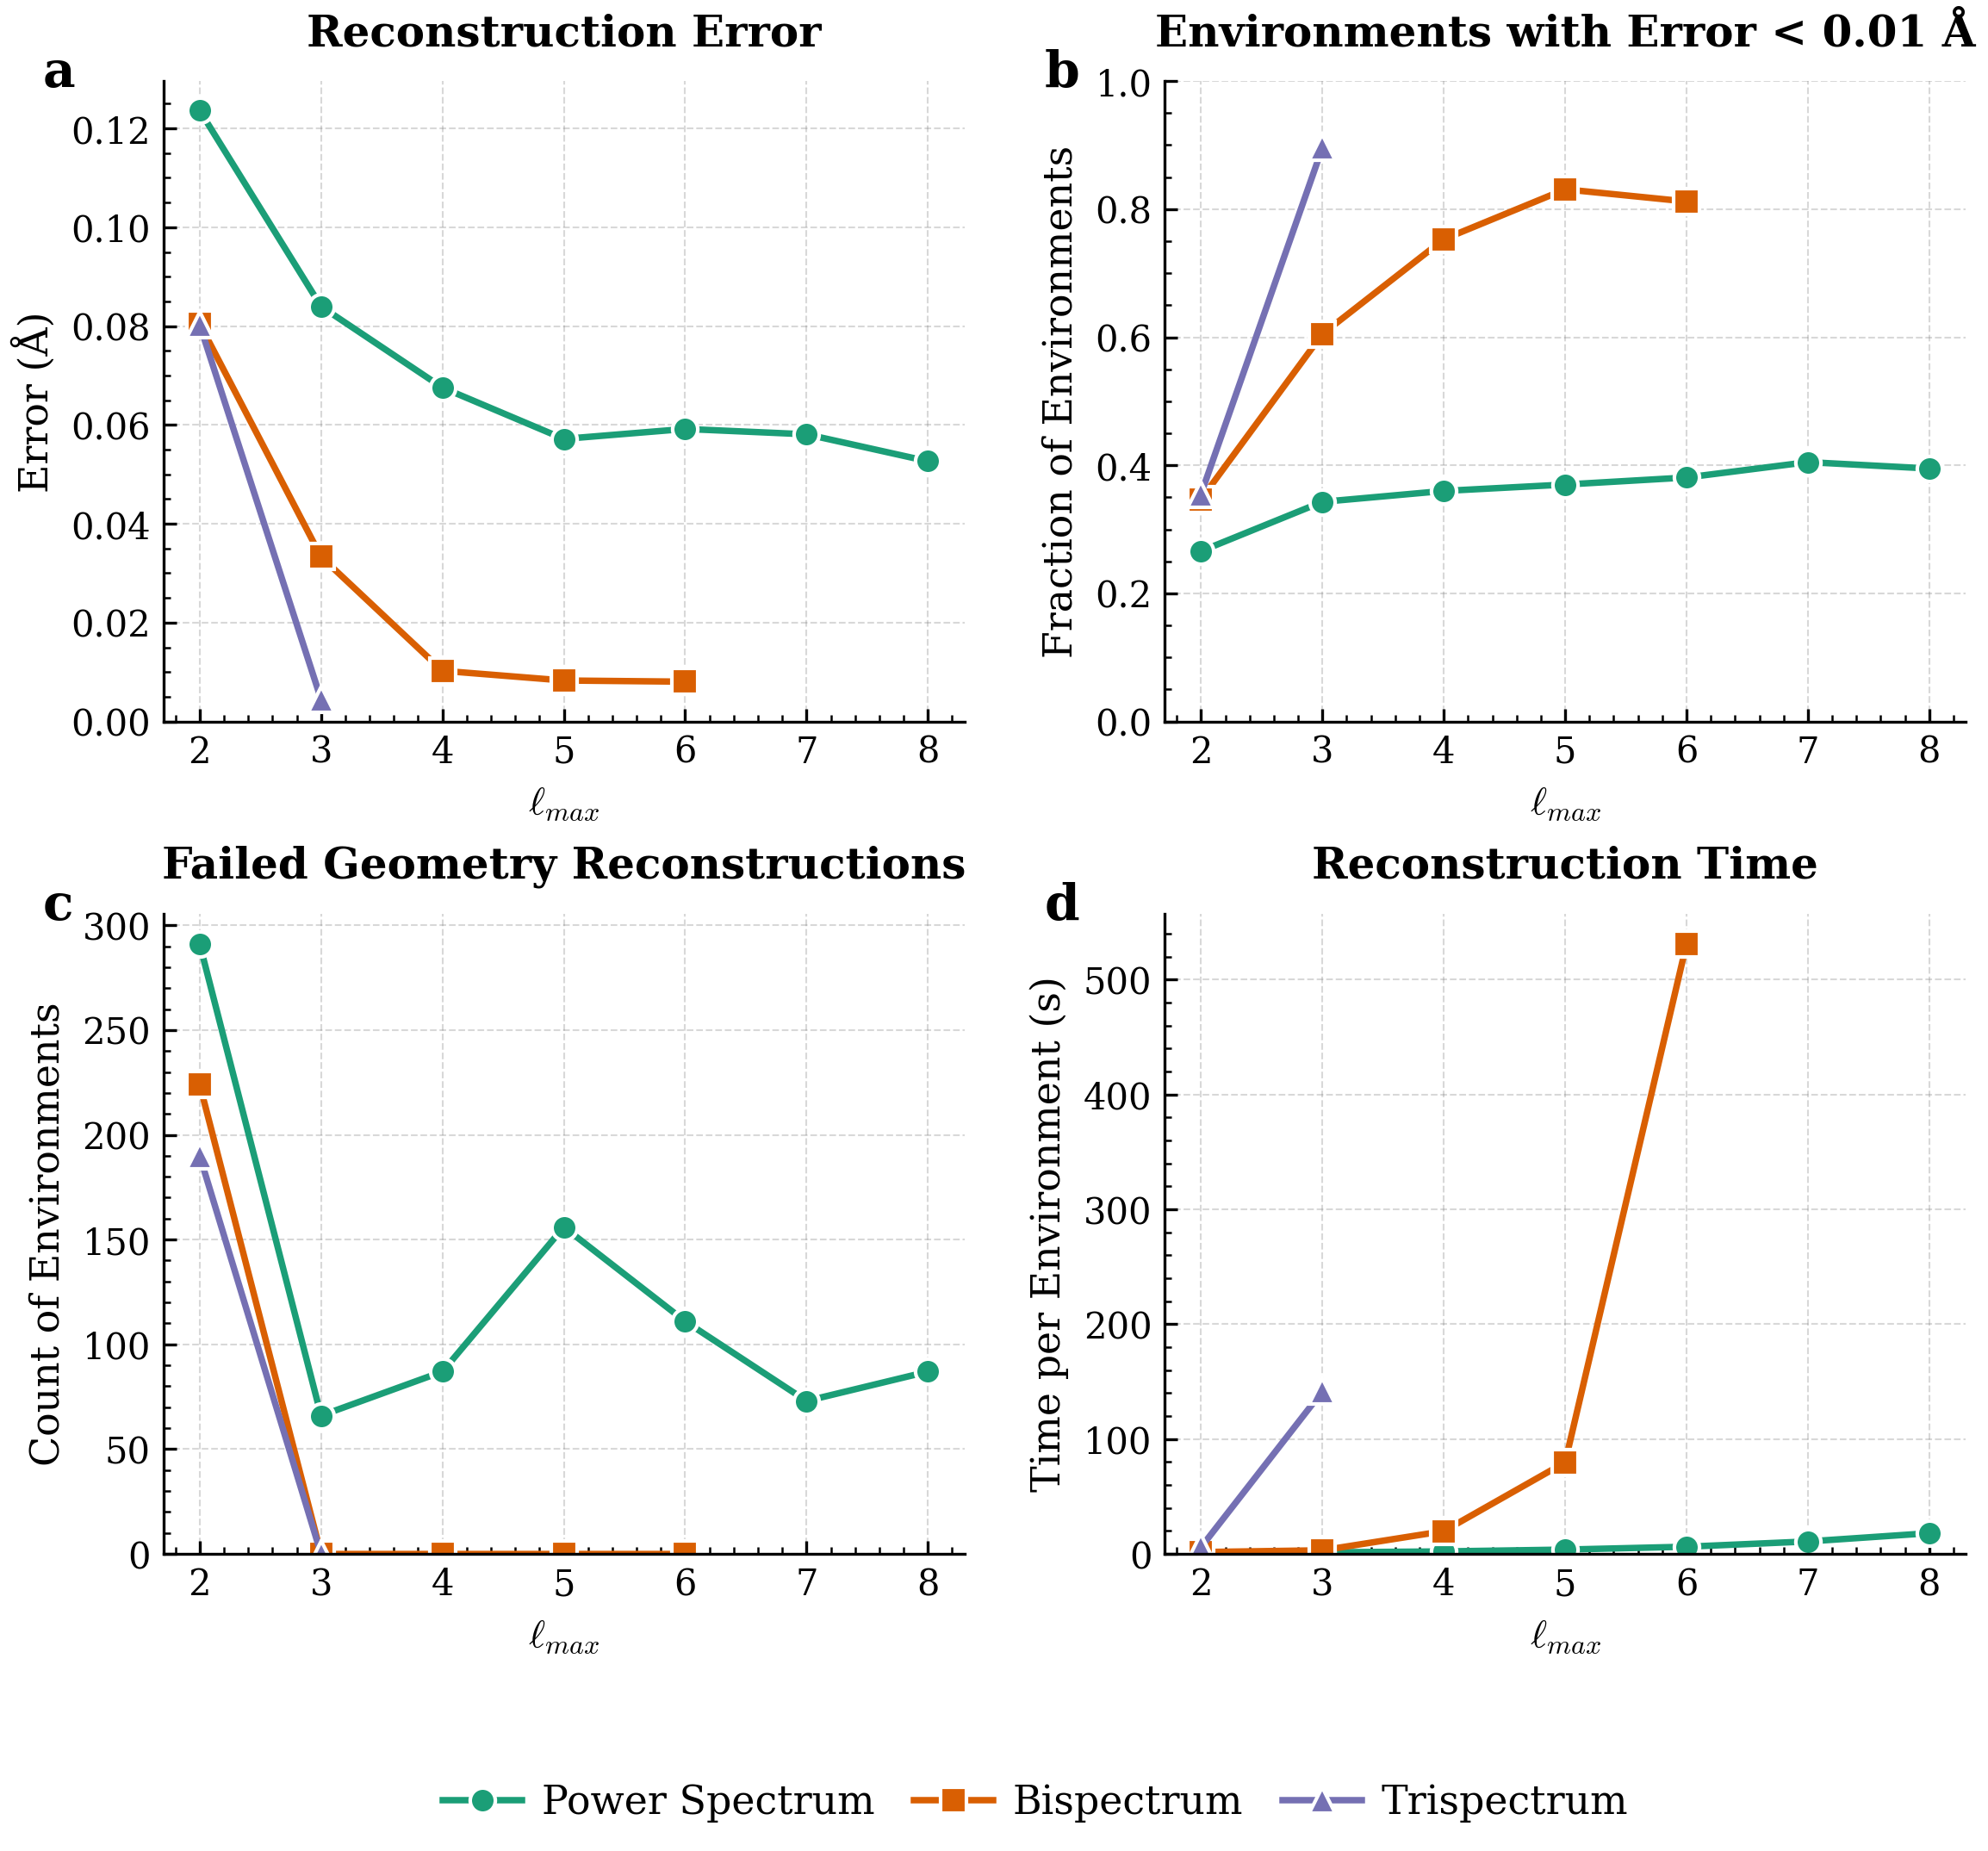

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
from matplotlib import gridspec
import matplotlib.ticker as ticker

# Set publication-quality plot style
plt.rcParams.update({
    'text.usetex': False,  # Don't use LaTeX for text rendering
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman'],
    'mathtext.fontset': 'cm',  # Still use Computer Modern for math
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.6,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 3.5,
    'ytick.major.size': 3.5,
    'xtick.minor.size': 2.0,
    'ytick.minor.size': 2.0,
    'axes.axisbelow': True,
    'axes.grid': False,
})

# Create a figure with four subplots in a 2x2 grid
fig = plt.figure(figsize=(9, 7.5))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.25, hspace=0.3)

# Create the subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Use a colorblind-friendly color palette
# From ColorBrewer2.org - colorblind safe, print friendly
colors = ['#1b9e77', '#d95f02', '#7570b3']
spectrum_colors = {
    'powerspectrum': colors[0],
    'bispectrum': colors[1],
    'trispectrum': colors[2]
}

# Add subplot labels
for ax, label in zip([ax1, ax2, ax3, ax4], ['a', 'b', 'c', 'd']):
    ax.text(-0.15, 1.05, label, transform=ax.transAxes, 
            fontsize=14, fontweight='bold', va='top')

# Calculate mean alignment MAE and fraction of non-inf values for each method
mean_maes = {}
invalid_alignment_counts = {}
low_mae_fractions = {}
processing_times_per_env = {}

for key in all_results.keys():
    spectrum_name, lmax = key
    
    # Get all MAE values and count non-inf ones
    all_maes = all_results[key]['alignment_mae']
    filtered_maes = [mae for mae in all_maes if not np.isinf(mae)]
    
    # Calculate mean and invalid counts
    mean_maes[key] = np.mean(filtered_maes) if filtered_maes else np.nan
    invalid_alignment_counts[key] = len(all_maes) - len(filtered_maes)
    
    # Calculate fraction of entries with MAE < 0.01
    low_mae_count = sum(1 for mae in all_maes if not np.isinf(mae) and mae < 0.01)
    low_mae_fractions[key] = low_mae_count / len(all_maes) if all_maes else 0
    
    # Calculate processing time per environment
    num_envs = len(local_envs)
    if 'processing_time' in all_results[key]:
        # Check if processing_time is already a total or a list
        if isinstance(all_results[key]['processing_time'], (int, float)):
            processing_times_per_env[key] = all_results[key]['processing_time'] / num_envs
        elif isinstance(all_results[key]['processing_time'], list):
            processing_times_per_env[key] = sum(all_results[key]['processing_time']) / num_envs
        else:
            processing_times_per_env[key] = np.nan
    else:
        processing_times_per_env[key] = np.nan

# Group data by spectrum type
spectrum_data = {}
for spectrum_name in set(key[0] for key in all_results.keys()):
    spectrum_data[spectrum_name] = {
        'lmax': [],
        'mae': [],
        'invalid_alignment_count': [],
        'low_mae_fraction': [],
        'processing_time': []
    }
    
    # Collect data for this spectrum type
    for key in all_results.keys():
        if key[0] == spectrum_name:
            spectrum_data[spectrum_name]['lmax'].append(key[1])
            spectrum_data[spectrum_name]['mae'].append(mean_maes[key])
            spectrum_data[spectrum_name]['invalid_alignment_count'].append(invalid_alignment_counts[key])
            spectrum_data[spectrum_name]['low_mae_fraction'].append(low_mae_fractions[key])
            spectrum_data[spectrum_name]['processing_time'].append(processing_times_per_env[key])
    
    # Sort by lmax
    sorted_indices = np.argsort(spectrum_data[spectrum_name]['lmax'])
    for key in spectrum_data[spectrum_name]:
        spectrum_data[spectrum_name][key] = [spectrum_data[spectrum_name][key][i] for i in sorted_indices]

# Define markers and line styles for better differentiation
markers = ['o', 's', '^']
marker_edge_width = 1.0

# Define better legend labels with spacing for LaTeX if needed
legend_elements = {
    'powerspectrum': 'Power Spectrum',
    'bispectrum': 'Bispectrum',
    'trispectrum': 'Trispectrum'
}

# Plot the data for each spectrum type
for i, spectrum_name in enumerate(["powerspectrum", "bispectrum", "trispectrum"]):
    data = spectrum_data[spectrum_name]
    color = spectrum_colors.get(spectrum_name, 'gray')
    label = legend_elements[spectrum_name]
    marker = markers[i]
    
    # Plot 1: Mean Alignment MAE
    ax1.plot(data['lmax'], data['mae'], marker=marker, linestyle='-', 
             linewidth=1.8, markersize=7, markeredgewidth=marker_edge_width,
             color=color, markerfacecolor=color, markeredgecolor='white',
             label=label)
    
    # Plot 2: Fraction of entries with MAE < 0.01
    ax2.plot(data['lmax'], data['low_mae_fraction'], marker=marker, linestyle='-', 
             linewidth=1.8, markersize=7, markeredgewidth=marker_edge_width,
             color=color, markerfacecolor=color, markeredgecolor='white',
             label=label)
    
    # Plot 3: Count of invalid alignments
    ax3.plot(data['lmax'], data['invalid_alignment_count'], marker=marker, linestyle='-', 
             linewidth=1.8, markersize=7, markeredgewidth=marker_edge_width,
             color=color, markerfacecolor=color, markeredgecolor='white',
             label=label)
    
    # Plot 4: Processing time per environment
    ax4.plot(data['lmax'], data['processing_time'], marker=marker, linestyle='-', 
             linewidth=1.8, markersize=7, markeredgewidth=marker_edge_width,
             color=color, markerfacecolor=color, markeredgecolor='white',
             label=label)

# Function to set scientific notation for large numbers
def sci_format(x, pos):
    if x == 0:
        return "0"
    exp = np.floor(np.log10(abs(x)))
    if abs(exp) > 2:
        return r'$%.1f \times 10^{%d}$' % (x / 10**exp, exp)
    else:
        return '%.3g' % x

# Format labels using matplotlib's built-in math renderer
ax1.set_xlabel(r'$\ell_{max}$', fontweight='normal')
ax1.set_ylabel(r'Error (Å)', fontweight='normal')
ax1.set_title(r'Reconstruction Error', fontweight='bold', pad=10)

# Axis 2: Fraction of entries with MAE < 0.01
ax2.set_xlabel(r'$\ell_{max}$', fontweight='normal')
ax2.set_ylabel(r'Fraction of Environments', fontweight='normal')
ax2.set_title(r'Environments with Error < 0.01 Å', fontweight='bold', pad=10)

# Axis 3: Count of invalid alignments  
ax3.set_xlabel(r'$\ell_{max}$', fontweight='normal')
ax3.set_ylabel(r'Count of Environments', fontweight='normal')
ax3.set_title(r'Failed Geometry Reconstructions', fontweight='bold', pad=10)

# Axis 4: Processing time per environment
ax4.set_xlabel(r'$\ell_{max}$', fontweight='normal')
ax4.set_ylabel(r'Time per Environment (s)', fontweight='normal')
ax4.set_title(r'Reconstruction Time', fontweight='bold', pad=10)

# Apply common formatting to all axes
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(True, linestyle='--', alpha=0.3, color='gray', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

# Set specific y-axis limits
ax1.set_ylim(bottom=0)  # Reconstruction Error
ax2.set_ylim(0, 1)   # Fraction of Environments
ax3.set_ylim(bottom=0)  # Failed Reconstructions
ax4.set_ylim(bottom=0)  # Computation Time

# Handle scientific notation for large numbers in plot 4
if any(not np.isnan(t) and t > 1000 for spectrum in spectrum_data.values() 
      for t in spectrum['processing_time']):
    ax4.yaxis.set_major_formatter(ticker.FuncFormatter(sci_format))

# Add a single legend outside the plots
handles, labels = ax1.get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.02),
                   fancybox=False, shadow=False, ncol=3, frameon=False,
                   fontsize=11, handletextpad=0.5, columnspacing=1.0)

# Adjust the figure layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)  # Make space for the legend at the bottom

# Save the figure in multiple formats suitable for publication
# PDF is best for LaTeX/Overleaf
plt.savefig('spectrum_comparison_plots.pdf', dpi=600, bbox_inches='tight')
plt.savefig('spectrum_comparison_plots.png', dpi=600, bbox_inches='tight')
plt.savefig('spectrum_comparison_plots.eps', format='eps', dpi=600, bbox_inches='tight')

plt.show()

/var/folders/7c/7cx32s8x1x32j9xw0z_x3y980000gn/T/ipykernel_52832/3261601499.py:171: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



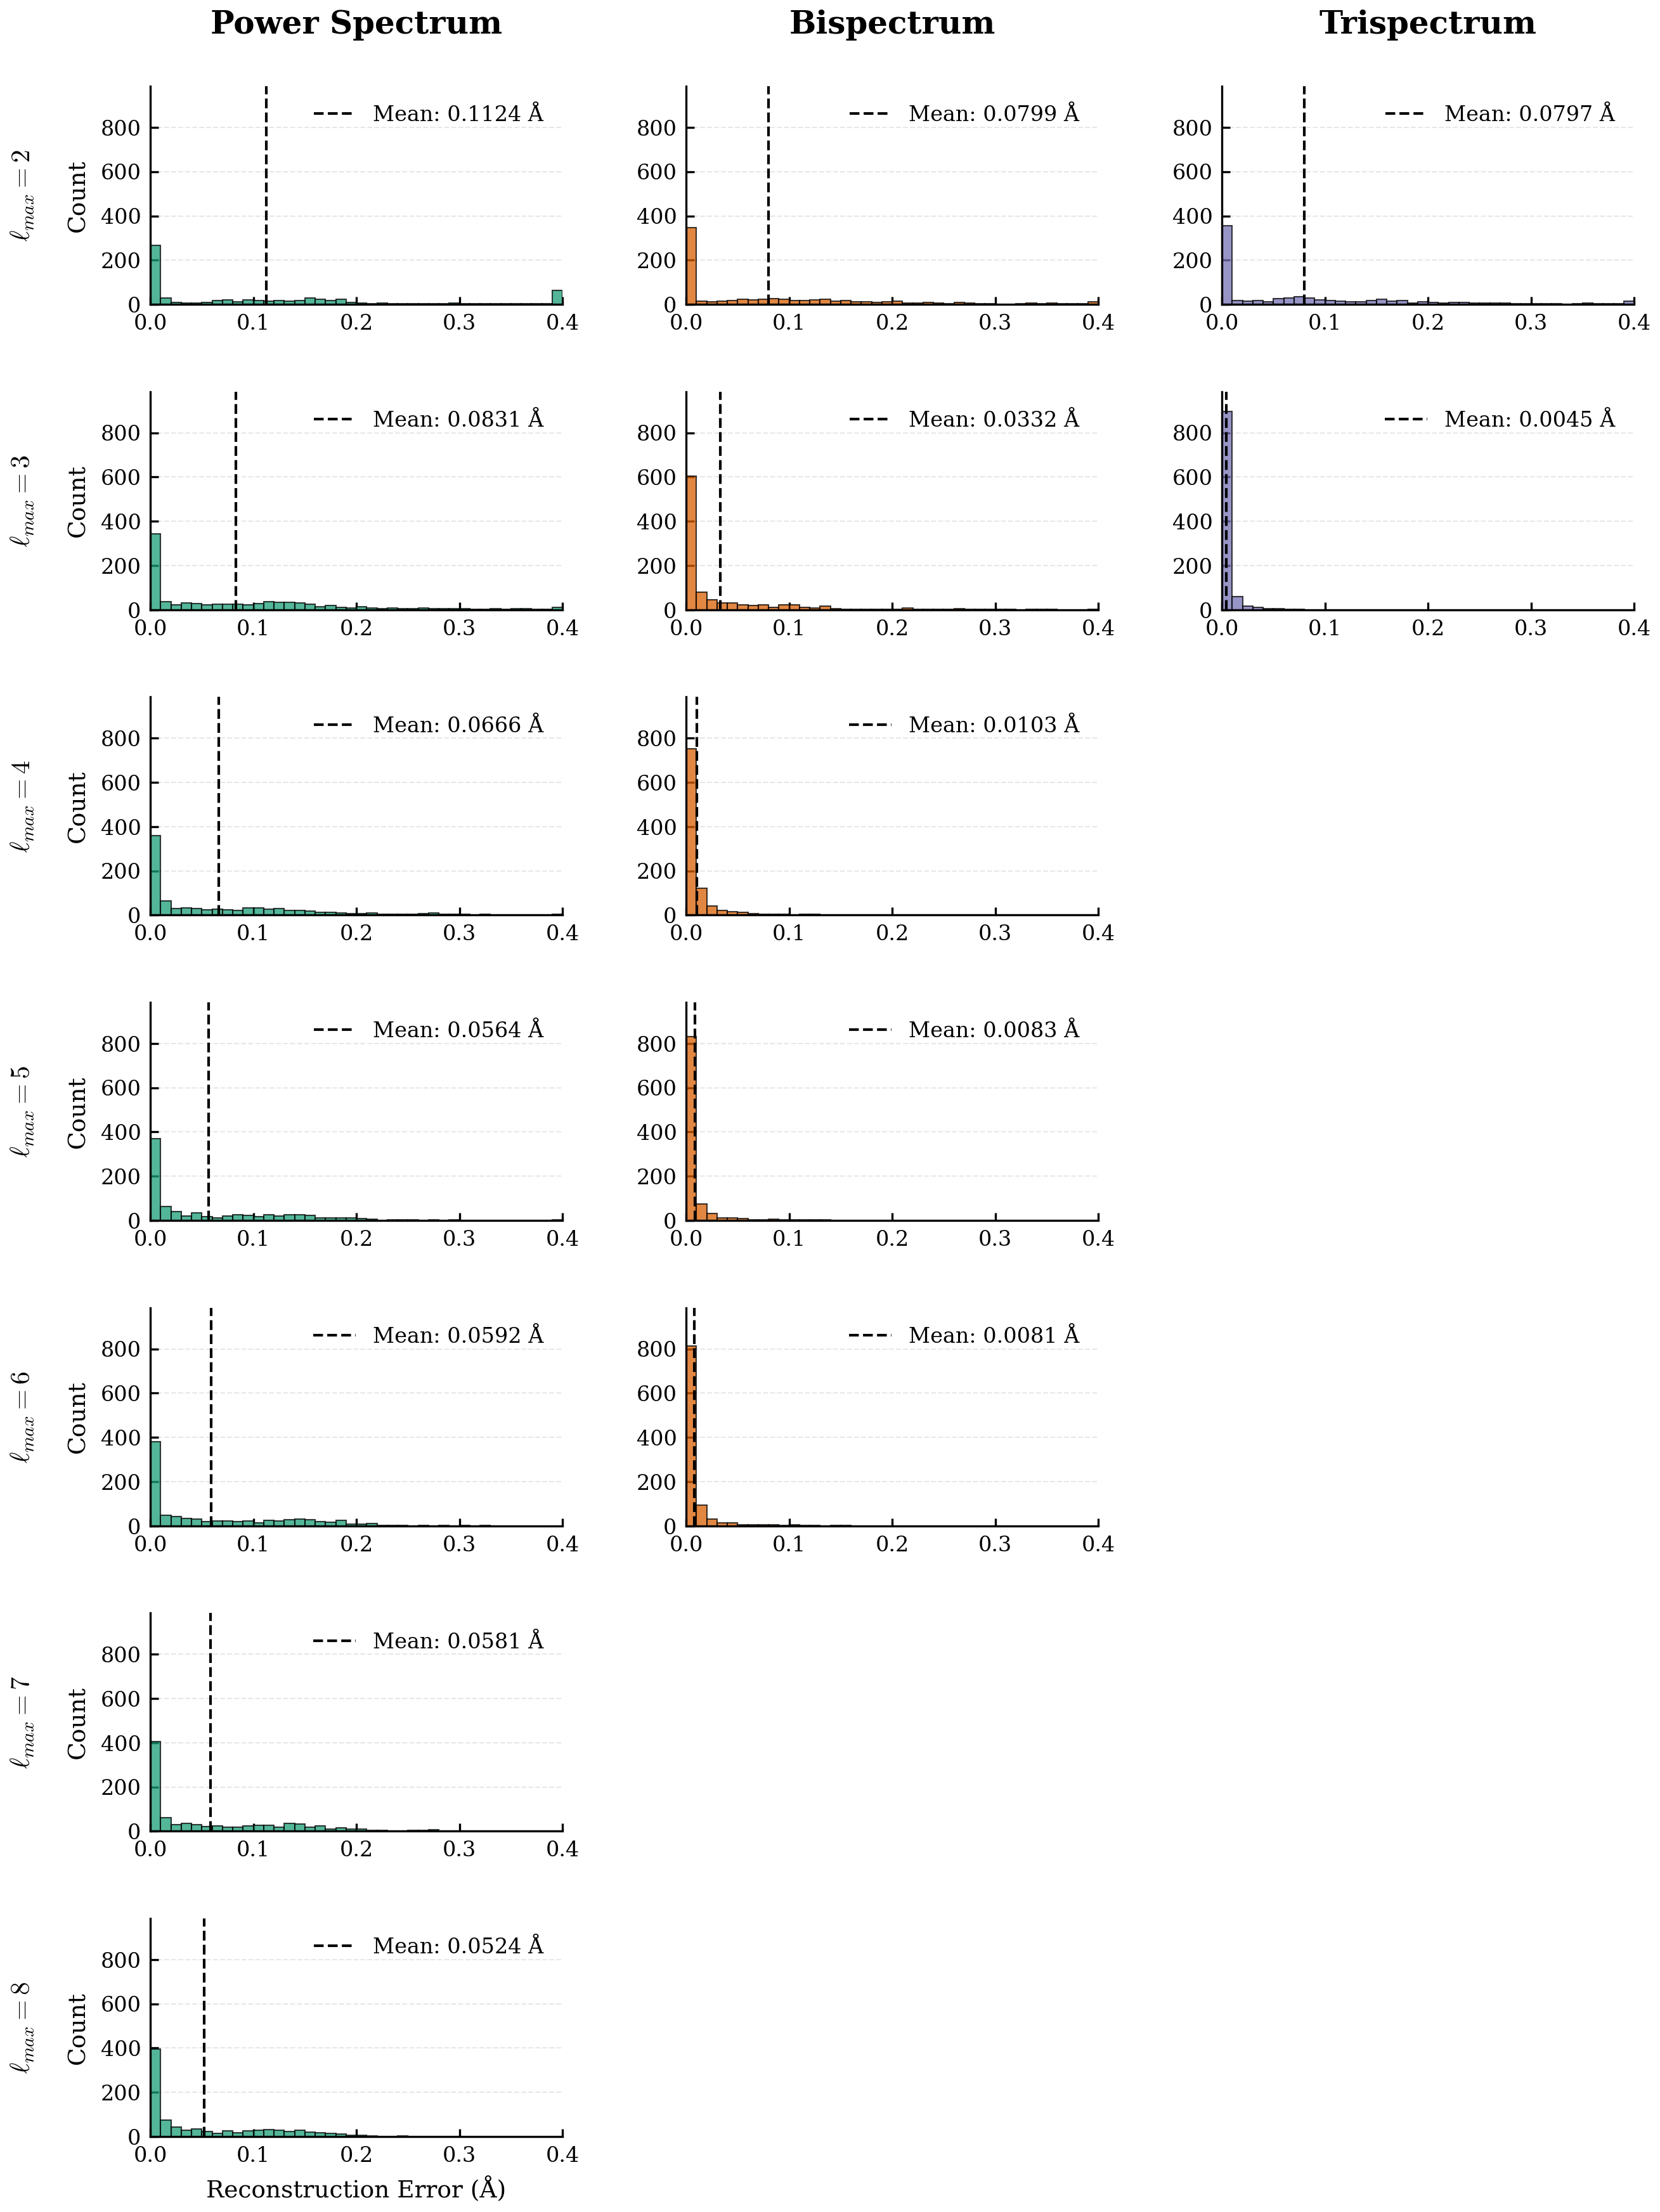

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.ticker as ticker

# Set publication-quality plot style
plt.rcParams.update({
    'text.usetex': False,  # Don't use LaTeX for text rendering
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman'],
    'mathtext.fontset': 'cm',  # Still use Computer Modern for math
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 9,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 3.0,
    'ytick.major.size': 3.0,
    'xtick.minor.size': 1.5,
    'ytick.minor.size': 1.5,
    'axes.axisbelow': True,
    'axes.grid': False,
})

# Define spectrum types and lmax values
spectrum_types = ["powerspectrum", "bispectrum", "trispectrum"]
lmax_values = list(range(2, 9))  # 2 through 8

# Define which lmax values are available for each spectrum type
lmax_available = {
    "powerspectrum": list(range(2, 9)),  # 2 through 8
    "bispectrum": list(range(2, 7)),     # 2 through 6
    "trispectrum": list(range(2, 4))     # 2 through 3
}

# Define better legend labels with spacing for LaTeX if needed
legend_elements = {
    'powerspectrum': 'Power Spectrum',
    'bispectrum': 'Bispectrum',
    'trispectrum': 'Trispectrum'
}

# Use a colorblind-friendly color palette
colors = ['#1b9e77', '#d95f02', '#7570b3']
spectrum_colors = {
    'powerspectrum': colors[0],
    'bispectrum': colors[1],
    'trispectrum': colors[2]
}

# Define fixed bins from 0 to 0.4 with overflow in the last bin
bins = np.linspace(0, 0.4, 41)  # 40 bins from 0 to 0.4 Å in increments of 0.01 Å
max_count = 0

# First pass to determine maximum count for consistent y-axis scaling
for row, lmax in enumerate(lmax_values):
    for col, spectrum in enumerate(spectrum_types):
        # Check if this combination exists
        if lmax in lmax_available[spectrum]:
            # Get the key for this combination
            key = (spectrum, lmax)
            
            # Get all MAE values and filter out infinities
            all_maes = all_results[key]['alignment_mae']
            # Clip values above 0.4 to be included in the last bin
            filtered_maes = [min(mae, 0.4) for mae in all_maes if not np.isinf(mae)]
            
            # Make a test histogram to find the max count
            hist, _ = np.histogram(filtered_maes, bins=bins)
            max_count = max(max_count, max(hist))

# Create a figure with a grid of subplots
fig = plt.figure(figsize=(10, 14))
gs = gridspec.GridSpec(7, 3, figure=fig, wspace=0.3, hspace=0.4, left=0.12)

# Dictionary to store subplot references for ℓmax label positioning
row_axes = {}

# Create the histograms
for row, lmax in enumerate(lmax_values):
    # Store axes for this row to position ℓmax labels later
    row_axes[row] = []
    
    for col, spectrum in enumerate(spectrum_types):
        # Create subplot
        ax = fig.add_subplot(gs[row, col])
        row_axes[row].append(ax)
        
        # Check if this combination exists
        if lmax in lmax_available[spectrum]:
            # Get the key for this combination
            key = (spectrum, lmax)
            
            # Get all MAE values and filter out infinities
            all_maes = all_results[key]['alignment_mae']
            # Clip values above 0.4 to be included in the last bin
            filtered_maes = [min(mae, 0.4) for mae in all_maes if not np.isinf(mae)]
            
            # Plot histogram
            if filtered_maes:
                hist, edges, patches = ax.hist(filtered_maes, bins=bins, 
                                              color=spectrum_colors[spectrum], 
                                              alpha=0.75, edgecolor='black', linewidth=0.5)
            
            # Add vertical line at the mean
            if filtered_maes:
                mean_error = np.mean(filtered_maes)
                ax.axvline(mean_error, color='black', linestyle='--', linewidth=1, 
                          label=f'Mean: {mean_error:.4f} Å')
                
            # Set consistent axis limits
            ax.set_xlim(bins[0], bins[-1])
            ax.set_ylim(0, max_count * 1.1)  # Add 10% padding at the top
            
            # Clean up appearance
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.grid(True, linestyle='--', alpha=0.3, axis='y')
            
            # Add legend only if data exists
            if filtered_maes:
                ax.legend(fontsize=8, frameon=False, loc='upper right')
            
            # Add spectrum titles to first row subplots
            if row == 0:
                ax.set_title(legend_elements[spectrum], fontsize=12, fontweight='bold', pad=20)
                
        else:
            # If this combination doesn't exist, hide the axes
            ax.set_visible(False)
        
        # Add labels only on the left side and bottom row
        if col == 0:
            ax.set_ylabel('Count')
        if row == 6:
            ax.set_xlabel('Reconstruction Error (Å)')

# Now add ℓmax labels to the left of each row, properly centered
for row, lmax in enumerate(lmax_values):
    # Get first visible axes in this row
    visible_axes = [ax for ax in row_axes[row] if ax.get_visible()]
    if visible_axes:
        # Get the first visible subplot for this row
        ax = visible_axes[0]
        
        # Get the position of the subplot to calculate the exact center
        pos = ax.get_position()
        row_center_y = (pos.y0 + pos.y1) / 2
        
        # Add the ℓmax label at the exact center of the subplot
        fig.text(0.06, row_center_y, f"$\\ell_{{max}} = {lmax}$", 
                ha='right', va='center', fontsize=10, fontweight='bold',
                rotation=90)  # Make text sideways like y-axis labels

# Adjust the figure layout
plt.tight_layout()

# Save the figure
plt.savefig('reconstruction_error_distributions.pdf', dpi=600, bbox_inches='tight')
plt.savefig('reconstruction_error_distributions.png', dpi=600, bbox_inches='tight')

plt.show()

In [8]:
spectrum_data['trispectrum']

{'lmax': [2, 3],
 'mae': [np.float64(0.08028248307566554), np.float64(0.0044861461100301515)],
 'invalid_alignment_count': [190, 0],
 'low_mae_fraction': [0.355, 0.896],
 'processing_time': [5.842160211801529, 141.63497397375107]}

In [9]:
spectrum_data['bispectrum']

{'lmax': [2, 3, 4, 5, 6],
 'mae': [np.float64(0.08045919549894169),
  np.float64(0.033328525973526146),
  np.float64(0.010255183276151322),
  np.float64(0.008290973390954807),
  np.float64(0.008054648440073572)],
 'invalid_alignment_count': [224, 0, 0, 0, 0],
 'low_mae_fraction': [0.347, 0.605, 0.753, 0.831, 0.812],
 'processing_time': [1.6730650658607482,
  3.203855914115906,
  19.866708176851272,
  79.766348590374,
  531.0643949341774]}

In [10]:
spectrum_data['powerspectrum']

{'lmax': [2, 3, 4, 5, 6, 7, 8],
 'mae': [np.float64(0.12361579880146552),
  np.float64(0.08397564481506122),
  np.float64(0.06755129580929163),
  np.float64(0.05717654839245237),
  np.float64(0.059187158461520055),
  np.float64(0.058105708025187344),
  np.float64(0.05265642276324854)],
 'invalid_alignment_count': [291, 66, 87, 156, 111, 73, 87],
 'low_mae_fraction': [0.266, 0.343, 0.36, 0.37, 0.381, 0.405, 0.395],
 'processing_time': [1.3305970861911773,
  1.4321391031742097,
  2.229251991510391,
  3.8171512269973755,
  6.321602917194366,
  10.915317886829376,
  18.09021735095978]}

In [11]:
lmax = 4
spectrum_data['powerspectrum']['mae'][lmax-2] / spectrum_data['bispectrum']['mae'][lmax-2]

np.float64(6.587039352712868)

In [12]:
spectrum_data['bispectrum']['processing_time'][lmax-2] / spectrum_data['powerspectrum']['processing_time'][lmax-2]

8.911827039970895

In [13]:
print(spectrum_data['powerspectrum']['invalid_alignment_count'])
print(spectrum_data['bispectrum']['invalid_alignment_count'])
print(spectrum_data['trispectrum']['invalid_alignment_count'])


[291, 66, 87, 156, 111, 73, 87]
[224, 0, 0, 0, 0]
[190, 0]


In [28]:
# Reload imports
import sys
import importlib
import spectra
from utils.plotters import visualize_signal, compare_geometries, compare_three_geometries
from utils.alignment import point_distance

# Reload modules to ensure we have the latest versions
importlib.reload(sys.modules['spectra'])
importlib.reload(sys.modules['utils.plotters'])
importlib.reload(sys.modules['utils.alignment'])

<module 'utils.alignment' from '/Users/tphung/MIT Dropbox/Tuong Phung/repos/pyspectra/src/utils/alignment.py'>

In [78]:
# Define rank (0 for max MAE, 1 for second highest, etc.)
rank = 158
# Sort the MAE values in descending order and get the indices
sorted_indices = np.argsort(all_results[('powerspectrum', 5)]['alignment_mae'])[::-1]
# Get the index of the desired rank
max_mae_idx = sorted_indices[rank]
max_mae_value = all_results[('powerspectrum', 5)]['alignment_mae'][max_mae_idx]
print(f"Rank {rank} alignment MAE: {max_mae_value:.6f} at index {max_mae_idx}")

# Get the corresponding geometry (true and predicted)
true_geometry = np.array(local_envs[max_mae_idx])
reconstructed_geometry = np.array(all_results[('powerspectrum', 5)]['aligned_preds'][max_mae_idx])

# Print the number of points in the geometry
print(f"Number of points in geometry: {true_geometry.shape[0]}")

# Set random seed for reproducibility
np.random.seed(39)

# Generate a random quaternion for rotation
from scipy.spatial.transform import Rotation as R
random_quat = R.random().as_quat()
random_rotation = R.from_quat(random_quat)

# Apply the same random rotation to both geometries
true_geometry_rotated = random_rotation.apply(true_geometry)
reconstructed_geometry_rotated = random_rotation.apply(reconstructed_geometry)

# Visualize the true and predicted geometries side by side
from utils.plotters import compare_geometries
compare_geometries(true_geometry_rotated, "True Geometry", 
                  reconstructed_geometry_rotated, "Predicted Geometry", 
                  lmax=6, show_points=True)

Rank 158 alignment MAE: 0.300474 at index 410
Number of points in geometry: 4


In [79]:
# Find the index of the maximum alignment MAE
# max_mae_idx = np.argmax(all_results[('bispectrum', 5)]['alignment_mae'])
max_mae_value = all_results[('bispectrum', 5)]['alignment_mae'][max_mae_idx]

print(f"Maximum alignment MAE: {max_mae_value:.6f} at index {max_mae_idx}")

# Get the corresponding geometry (true and predicted)
true_geometry = np.array(local_envs[max_mae_idx])
reconstructed_geometry = np.array(all_results[('bispectrum', 5)]['aligned_preds'][max_mae_idx])

true_geometry_rotated_bispectrum = random_rotation.apply(true_geometry)
reconstructed_geometry_rotated_bispectrum = random_rotation.apply(reconstructed_geometry)

# Print the number of points in the geometry
print(f"Number of points in geometry: {true_geometry.shape[0]}")

# Visualize the true and predicted geometries side by side
from utils.plotters import compare_geometries
compare_geometries(true_geometry_rotated_bispectrum, "True Geometry", 
                  reconstructed_geometry_rotated_bispectrum, "Predicted Geometry", 
                  lmax=6, show_points=True)

Maximum alignment MAE: 0.003050 at index 410
Number of points in geometry: 4


In [72]:
compare_three_geometries(true_geometry_rotated, "True Geometry", 
                         reconstructed_geometry_rotated, "Predicted Geometry (Power Spectrum)", 
                         reconstructed_geometry_rotated_bispectrum, "Predicted Geometry (Bispectrum)", 
                         lmax=6, show_points=False)

In [46]:
import plotly.graph_objects as go

plot_points = lambda x: go.Scatter3d(
    x=x[:, 0], 
    y=x[:, 1], 
    z=x[:, 2], 
    mode='markers', 
    marker=dict(size=10)
)

go.Figure([
    plot_points(true_geometry),
    plot_points(reconstructed_geometry)
])

In [117]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from PIL import Image
import matplotlib as mpl

# Set publication-quality plot style
plt.rcParams.update({
    'text.usetex': False,  # Don't use LaTeX for text rendering
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman'],
    'mathtext.fontset': 'cm',  # Still use Computer Modern for math
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 600,
})

# Load the original image
img = np.array(Image.open('bispectra_inversion_to_SHs_points.png'))
height, width, _ = img.shape

# Create a figure with the image and extra space for titles
fig, ax = plt.subplots(figsize=(width/100, height/100 + 1.5))  # More space at the top for 2-line titles

# Hide axes
ax.axis('off')

# Display the image
ax.imshow(img)

# Set the image position to leave space at the top for titles
ax.imshow(img, extent=[0, width, 0, height])
ax.set_position([0, 0, 1, height/(height+100)])  # Adjust image position to make room for titles

# Define column titles with line breaks
titles = [
    "Ground Truth", 
    "Reconstruction to\nSpherical Harmonics", 
    "Reconstruction to\n3D Points"
]

# Add column titles at the top, centered over each column
for i, title in enumerate(titles):
    # Calculate the center position of each column
    x_pos = width * (i + 0.5) / 3
    
    # Add the title with increased font size and moved higher up
    fig.text(x_pos/width, 0.91, title,  # Changed from 0.97 to 0.99 to move titles up
             ha='center', va='top',     # Changed to 'top' alignment instead of 'center'
             fontsize=18, fontweight='bold',
             fontfamily='serif')

# Save the image with titles
plt.savefig('bispectra_inversion_to_SHs_points_with_titles.jpg', 
           dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('bispectra_inversion_to_SHs_points_with_titles.pdf', 
           dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.close()

# Display the modified image dimensions
original_size = f"Original image size: {width} x {height} pixels"
print(original_size)
print("New image saved as: bispectra_inversion_to_SHs_points_with_titles.jpg and bispectra_inversion_to_SHs_points_with_titles.pdf")

Original image size: 1116 x 626 pixels
New image saved as: bispectra_inversion_to_SHs_points_with_titles.jpg and bispectra_inversion_to_SHs_points_with_titles.pdf


In [98]:
import plotly.graph_objects as go
import numpy as np

# Create figure
fig = go.Figure()

# Add scatter traces for the data points
fig.add_trace(go.Scatter3d(
    x=true_geometry[:, 0],
    y=true_geometry[:, 1],
    z=true_geometry[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color='#4285F4',  # Blue
        opacity=0.8,
        line=dict(width=1, color='#000000')
    ),
    name='True Geometry'
))

fig.add_trace(go.Scatter3d(
    x=reconstructed_geometry[:, 0],
    y=reconstructed_geometry[:, 1],
    z=reconstructed_geometry[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color='#EA4335',  # Red
        opacity=0.8,
        line=dict(width=1, color='#000000')
    ),
    name='Reconstructed Geometry'
))

# Enhanced depth perception: Add vertical lines from points to the bottom plane
for i in range(len(true_geometry)):
    x, y, z = true_geometry[i]
    z_min = min(true_geometry[:, 2].min(), reconstructed_geometry[:, 2].min()) - 0.1
    
    fig.add_trace(go.Scatter3d(
        x=[x, x],
        y=[y, y],
        z=[z, z_min],
        mode='lines',
        line=dict(color='#4285F4', width=1, dash='dot'),
        showlegend=False,
        opacity=0.3
    ))
    
    x, y, z = reconstructed_geometry[i]
    fig.add_trace(go.Scatter3d(
        x=[x, x],
        y=[y, y],
        z=[z, z_min],
        mode='lines',
        line=dict(color='#EA4335', width=1, dash='dot'),
        showlegend=False,
        opacity=0.3
    ))

# Configure for publication quality
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title=dict(text='x', font=dict(size=14)),
            tickfont=dict(size=12),
            gridcolor='rgba(200, 200, 200, 1.0)',  # More visible grid lines
            showbackground=True,
            backgroundcolor='rgba(240, 240, 240, 0.8)'  # More visible background
        ),
        yaxis=dict(
            title=dict(text='y', font=dict(size=14)),
            tickfont=dict(size=12),
            gridcolor='rgba(200, 200, 200, 1.0)',  # More visible grid lines
            showbackground=True,
            backgroundcolor='rgba(240, 240, 240, 0.8)'  # More visible background
        ),
        zaxis=dict(
            title=dict(text='z', font=dict(size=14)),
            tickfont=dict(size=12),
            gridcolor='rgba(200, 200, 200, 1.0)',  # More visible grid lines
            showbackground=True,
            backgroundcolor='rgba(240, 240, 240, 0.8)'  # More visible background
        ),
        aspectratio=dict(x=1, y=1, z=1),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.0)  # Adjusted for better view
        )
    ),
    legend=dict(
        x=0.01,
        y=0.99,
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='rgba(0, 0, 0, 0.3)',
        borderwidth=1
    ),
    font=dict(
        family='Arial, sans-serif',  # Standard font that's always available
        size=14
    ),
    margin=dict(l=0, r=0, t=10, b=0),
    width=700,
    height=600,
    # paper_bgcolor='rgba(240, 240, 240, 1)',  # Add background color to the entire plot
    # plot_bgcolor='rgba(240, 240, 240, 1)'    # Add background color to the plot area
)

# Show interactive plot
fig.show()

# Save as HTML (can be opened in any browser)
fig.write_html('/tmp/publication_3d_plot.html')

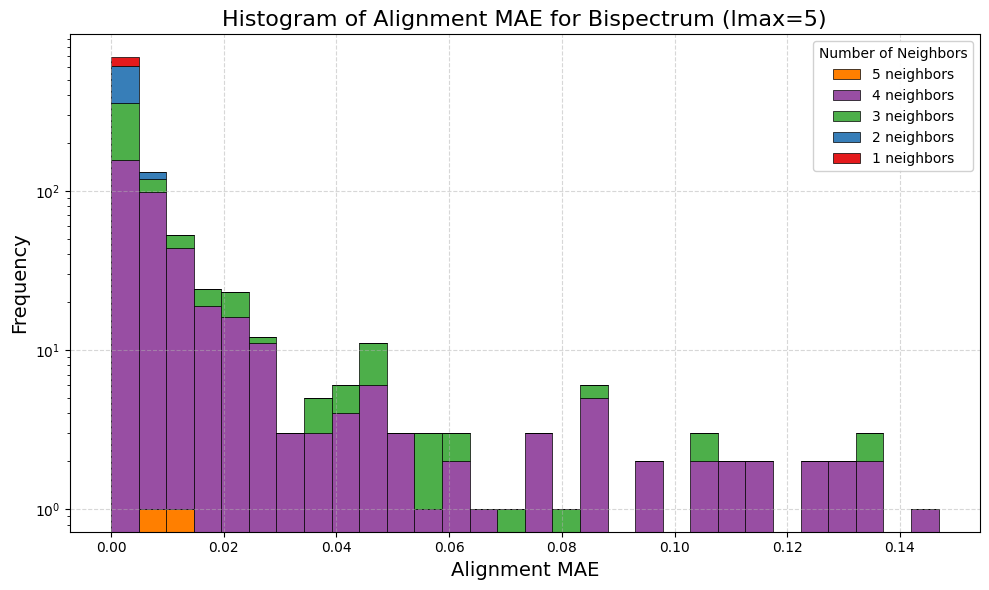

In [26]:
# Get the alignment MAE values
alignment_mae_values = all_results[('bispectrum', 5)]['alignment_mae']

# Get the number of neighbors for each data point
neighbor_counts = [all_results[('bispectrum', 5)]['best_preds'][index].shape[0] for index in range(len(alignment_mae_values))]

# Create a colormap based on number of neighbors with a more distinct color scheme
unique_counts = sorted(set(neighbor_counts))
# Using a color-blind friendly palette with high contrast
distinct_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
# If we have more unique counts than colors, we'll cycle through them
colors = {count: distinct_colors[i % len(distinct_colors)] for i, count in enumerate(unique_counts)}

# Group data points by neighbor count
grouped_data = {}
for mae, count in zip(alignment_mae_values, neighbor_counts):
    if count not in grouped_data:
        grouped_data[count] = []
    grouped_data[count].append(mae)

# Create a histogram with stacked bars
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(alignment_mae_values, bins=30, alpha=0.0)  # Invisible histogram to get bin edges

# Plot each group with stacked bars
counts_ordered = sorted(grouped_data.keys(), reverse=True)  # Start with largest count for better stacking
hist_data = []
hist_labels = []
hist_colors = []

for count in counts_ordered:
    hist_data.append(grouped_data[count])
    hist_labels.append(f'{count} neighbors')
    hist_colors.append(colors[count])

plt.hist(hist_data, bins=bins, stacked=True, color=hist_colors, 
         edgecolor='black', linewidth=0.5, label=hist_labels)

plt.xlabel('Alignment MAE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yscale('log')
plt.title('Histogram of Alignment MAE for Bispectrum (lmax=5)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Number of Neighbors', framealpha=0.9)  # More visible legend
plt.tight_layout()
plt.show()